In [6]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
wv = api.load('glove-wiki-gigaword-300')

In [7]:
csv1 = "../../data/cleaned/final_clean_data1.csv"
csv2 = "../../data/cleaned/final_clean_data2.csv"
base_texts = pd.read_csv(csv1).iloc[:, 0]
anomaly_texts = pd.read_csv(csv2).iloc[:, 0]

In [8]:
def key_words(column, top_n=20):
    """
    En utilisant la métrique tf-dif, la fonction retourne les top_n premiers mots-clés dans le dataset.
    """
    vectorizer = TfidfVectorizer()
    x = vectorizer.fit_transform(column)
    feature_names = vectorizer.get_feature_names_out()
    
    kw_per_text = []
    for doc_idx in range(x.shape[0]):
        # récupérer les scores tf-dif pour le texte courant
        tfidf_scores = x[doc_idx].toarray()[0]

        # associer chaque mot avec son score tf-dif
        word_scores = [(feature_names[i], tfidf_scores[i]) for i in range(len(feature_names))]

        # trier les mots par score décroissant
        sorted_words = sorted(word_scores, key=lambda x: x[1], reverse=True)

        # récupérer les top_n mots-clés
        keywords = [word for word, score in sorted_words[:top_n]]
        kw_per_text.append(keywords)

    return kw_per_text

In [9]:
def contamination_function(data1, data2, contamination_rate=0.5):
    contaminated_texts = []
    contamination_log = []
    data1_kw = key_words(data1)
    data2_kw = key_words(data2)
    
    #on prend 15% des documents 
    df_size = max(1, int(len(data1) * 0.15))  
    selected_indices = random.sample(range(len(data1)), df_size)


    #pour mesurer la similarité entre les mots-clés
    vectorizer = TfidfVectorizer()
    all_keywords = data1_kw + data2_kw
    tfidf_matrice = vectorizer.fit_transform([' '.join(kw) for kw in all_keywords]) #matrice de tout les mots clés
    base_vectors = tfidf_matrice[:len(data1_kw)] 
    anomaly_vectors = tfidf_matrice[len(data1_kw):]
    
    for i in selected_indices:
        base_text = data1[i]
        words = base_text.split()  
        total_words = len(words)
        words_to_contaminate = max(1, int(total_words * contamination_rate))  # mots à contaminer
        # trouver les anomalies les moins similaires (mots clés du text avec toutes les anomalies)
        similarities = cosine_similarity(base_vectors[i], anomaly_vectors)
        best_anomaly_idx = similarities.argmin()
        anomaly_text = data2[best_anomaly_idx]
        anomaly_words = anomaly_text.split()  # les mots de l'anomalie
        # tontaminer les mots du texte de base
        contaminated_words = words[:]
        contaminated_positions = []

        for _ in range(words_to_contaminate):
            # choisir un mot d'anomalie aléatoire
            anomaly_word = random.choice(anomaly_words)
            #position aléatoire dans le document de base
            position = random.randint(0, total_words - 1)

            # mettre le mot à cette position
            contaminated_words[position] = anomaly_word
            contaminated_positions.append((position, anomaly_word))

        #le texte contaminé
        contaminated_text = ' '.join(contaminated_words)
        contaminated_texts.append(contaminated_text)
        data1[i] = contaminated_text

        #résumé des contaminations (à supprimer aprés)
        contamination_log.append({
            "base_text": base_text,
            "contaminated_text": contaminated_text,
            "contaminated_positions": contaminated_positions,
            "anomaly_text": anomaly_text
        })

    return data1, contamination_log, selected_indices

In [10]:
contaminated, log, indices = contamination_function(base_texts, anomaly_texts)
log

[{'base_text': 'heart_size borderline enlarged focal alveolar consolidation definite pleural effusion seen typical finding pulmonary edema dense nodule right lower lobe suggests previous granulomatous process borderline heart_size acute pulmonary finding',
  'contaminated_text': 'heart_size borderline thecal focal noted herniation significant pleural effusion root typical finding evidence thecal dense thecal right lower lobe suggests previous noted thecal root heart_size acute pulmonary finding',
  'contaminated_positions': [(13, 'thecal'),
   (15, 'disc'),
   (15, 'thecal'),
   (9, 'root'),
   (21, 'noted'),
   (6, 'disc'),
   (5, 'herniation'),
   (2, 'thecal'),
   (12, 'evidence'),
   (4, 'noted'),
   (23, 'herniation'),
   (22, 'thecal'),
   (6, 'significant'),
   (23, 'root')],
  'anomaly_text': 'evidence disc herniation significant thecal sac nerve root compression noted'},
 {'base_text': 'change lung clear epanded heart mediastinum normal active disease visible cardiopulmonary i

In [11]:
def vectorisation_glove(data, wv, indice_anomalie=None):
    """
    Fonction qui vectorise les données textuelles en utilisant le modèle GLOVE, puis réduit les dimensions 
    des vecteurs pour les afficher graphiquement dans un espace 2D.
    
    - data : liste de document (chaque texte sera vectorisé mot par mot, puis moyenné).
    - wv : Le modèle GLOVE chargé ('glove-wiki-gigaword-300').
    - indice_anomalie : les indices des documents ou on a injecté des anomalies. 
    
    retourne la liste des vecteurs correspondant aux textes ou chaque document sera présenté par un point.
    """
    
    def vectoriser_texte(texte, wv, embedding_dim=300):
        """
        Vectorise un texte en moyennant les vecteurs de ses mots. 
        Si un mot n'existe pas dans le modèle GLOVE, il est ignoré.
        """
        mots = texte.split()
        vecteurs = [wv[mot] for mot in mots if mot in wv]  # extraire les vecteurs des mots existants dans GLOVE
        return np.mean(vecteurs, axis=0) if vecteurs else np.zeros(embedding_dim)  # retourner le vecteur moyen

    # vectorisation de tous les textes
    vecteurs = [vectoriser_texte(texte, wv) for texte in data]
    vecteurs = np.array(vecteurs)

    # réduction de la dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)  # réduire à 2 dimensions
    vecteurs_2d = tsne.fit_transform(vecteurs)  # appliquer t-SNE
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    # affichage graphique des données dans l'espace 2D
    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs


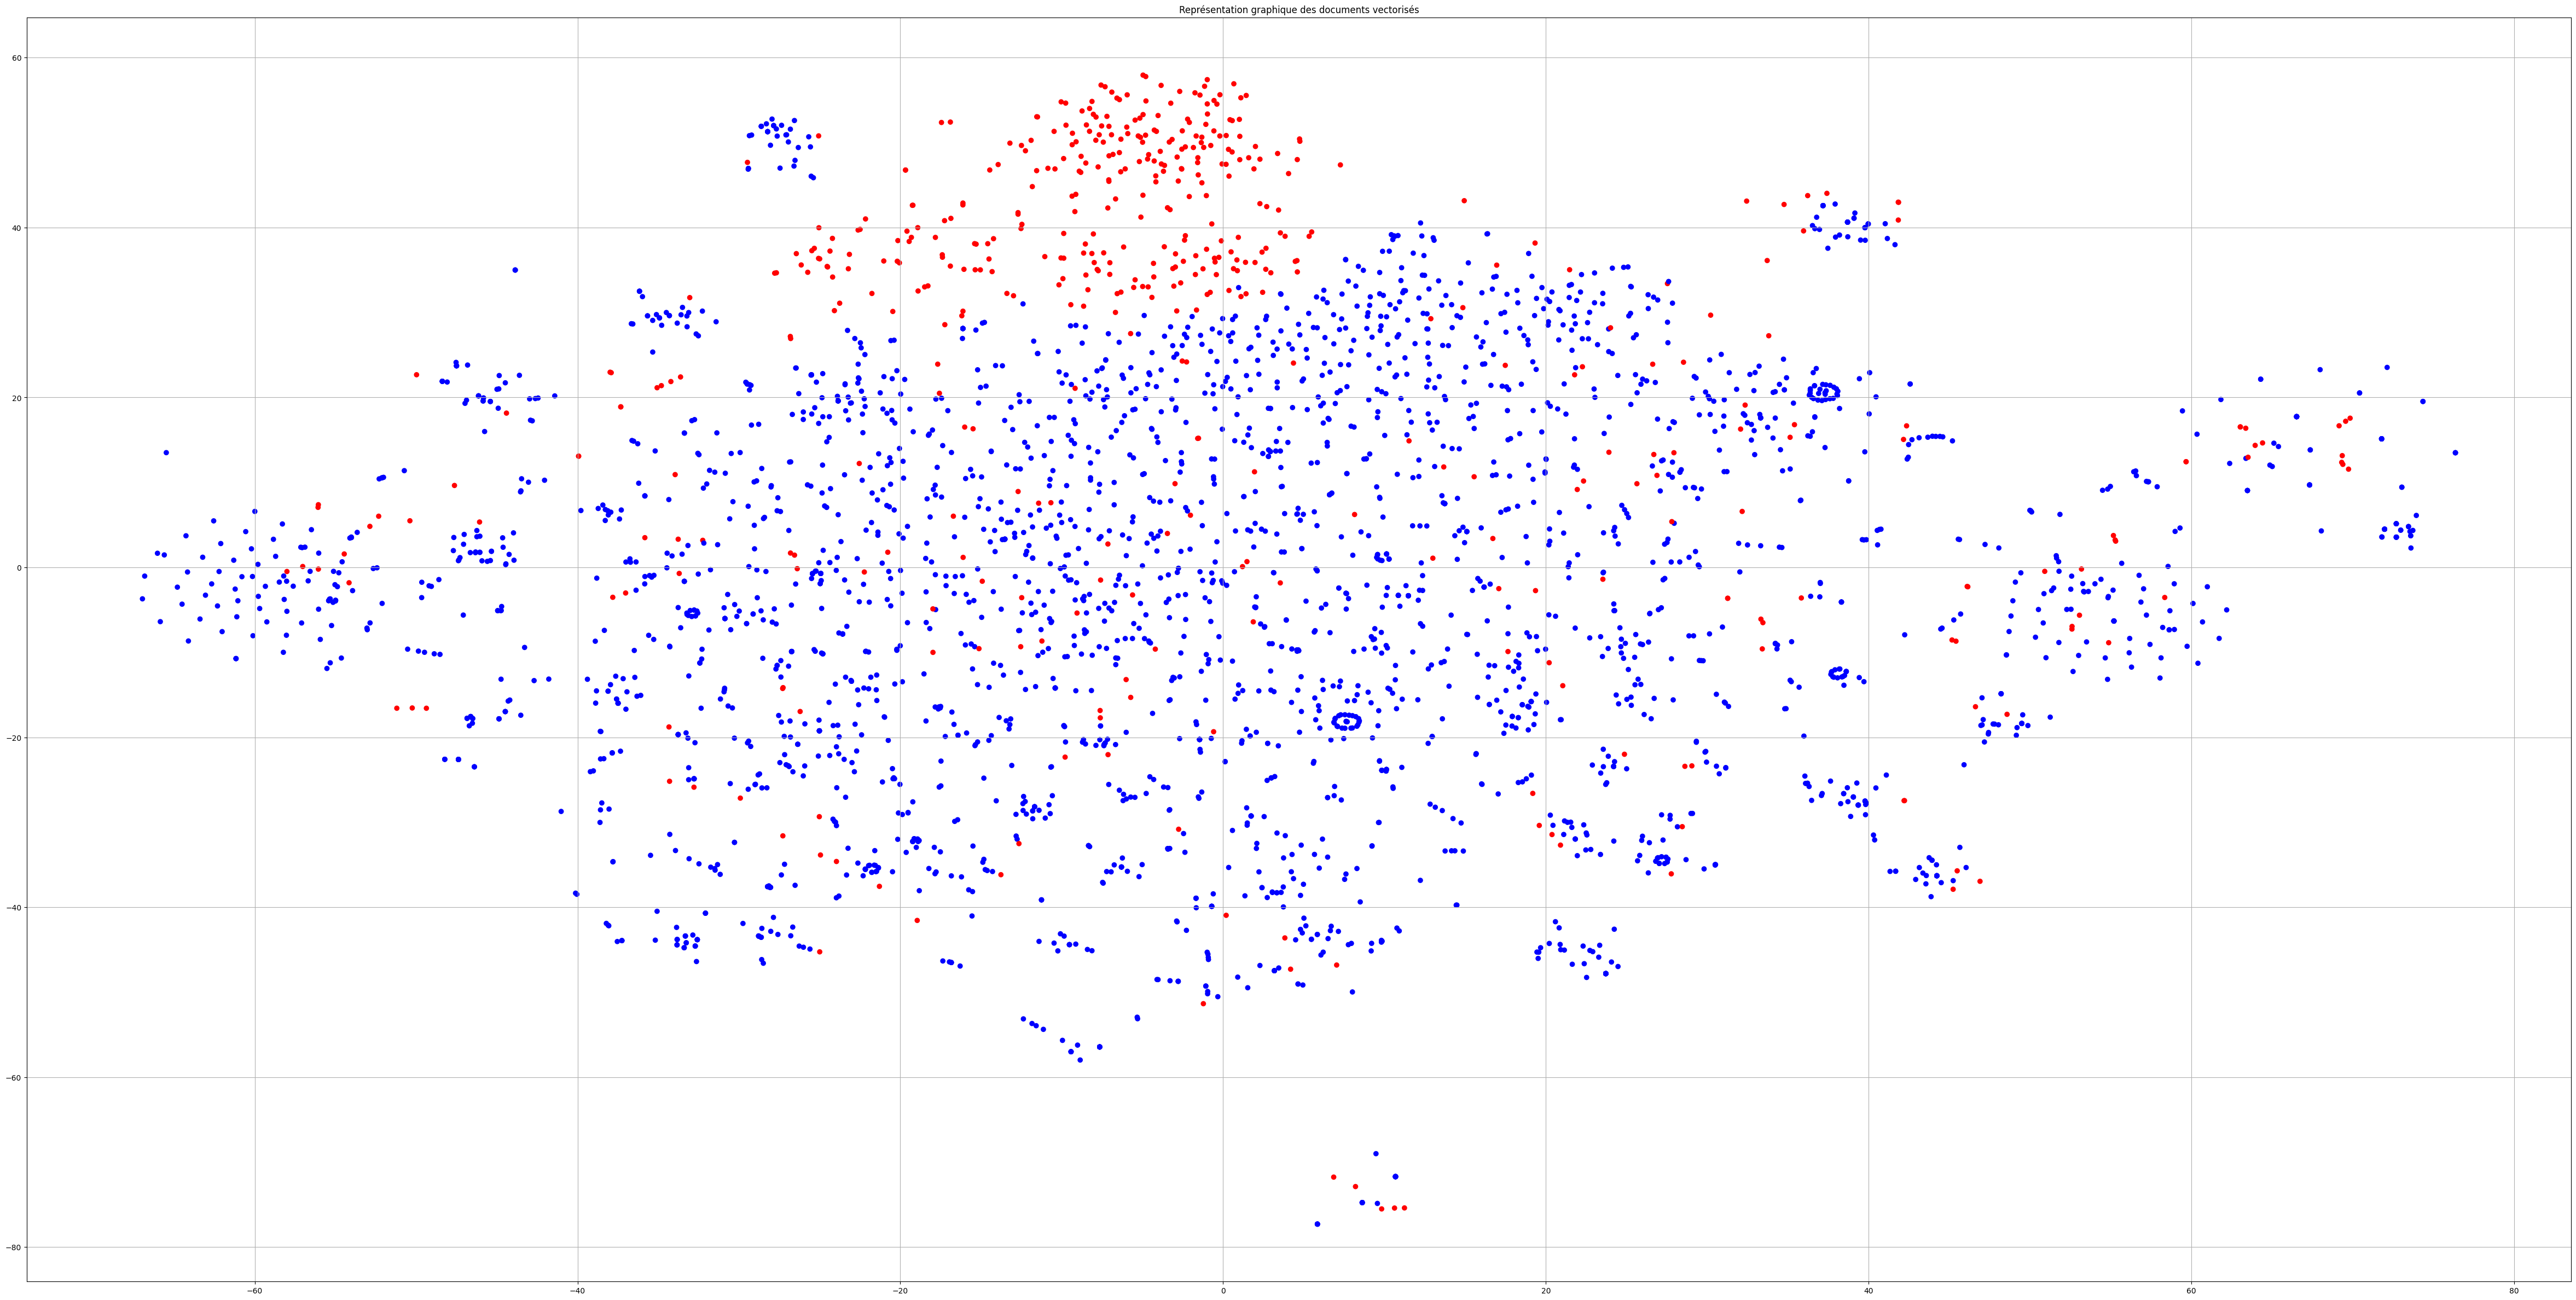

array([[-0.24678329,  0.12556681,  0.01996319, ..., -0.1001235 ,
        -0.00785575, -0.19792338],
       [-0.20530856,  0.17592609,  0.0133449 , ..., -0.19303708,
         0.05247247, -0.23319836],
       [-0.33040616, -0.04434942,  0.26378086, ..., -0.17089991,
        -0.03175143, -0.26263165],
       ...,
       [-0.24485153,  0.09860811, -0.09334222, ..., -0.09987008,
         0.00411144, -0.31958839],
       [-0.19477817,  0.18117069,  0.0568497 , ...,  0.0003723 ,
         0.03765953, -0.36902636],
       [-0.11742996,  0.11554985,  0.14990243, ...,  0.07082912,
         0.18521918, -0.27381435]])

In [12]:
vectorisation_glove(contaminated, wv, indices)

In [13]:
def contamination_function_bis(data1, data2, contamination_rate=0.1):
    """
    Fonction qui génère des anomalie dans notre jeu de données data1, en injectant des donnée de data2.
    
    - data1 : Corpus de données sain
    - data2 : Corpus de données considérées "anomalie"
    - contamination_rate : le taux de document contaminé par rapport a la taille de data1
    
    retourne un nouveau corpus de données avec des anomalies + les indices des anomalies
    """
    contamination_log = []
    
    #on contamine % des documents dans data1 
    df_size = max(1, int(len(data1) * contamination_rate))  
    selected_indices = random.sample(range(len(data1)), df_size)
    
    for i in selected_indices:
        base_text = data1[i]
        new_text = random.choice(data2)
        data1[i] = new_text  # remplacement de la ligne 

        # un log pour surveiller le fonctionnement de la fonction (à ajouter dans le return)
        contamination_log.append({
            "base_text": base_text,  # le texte original avant remplacement
            "contaminated_text": new_text,  # le texte après remplacement
            "index_replaced": i  # l'index de la ligne modifiée
        })

    return data1, selected_indices

In [14]:
data_new, ind= contamination_function_bis(base_texts, anomaly_texts)

In [18]:
#data_new.to_csv("contaminated_data.csv", index = False)

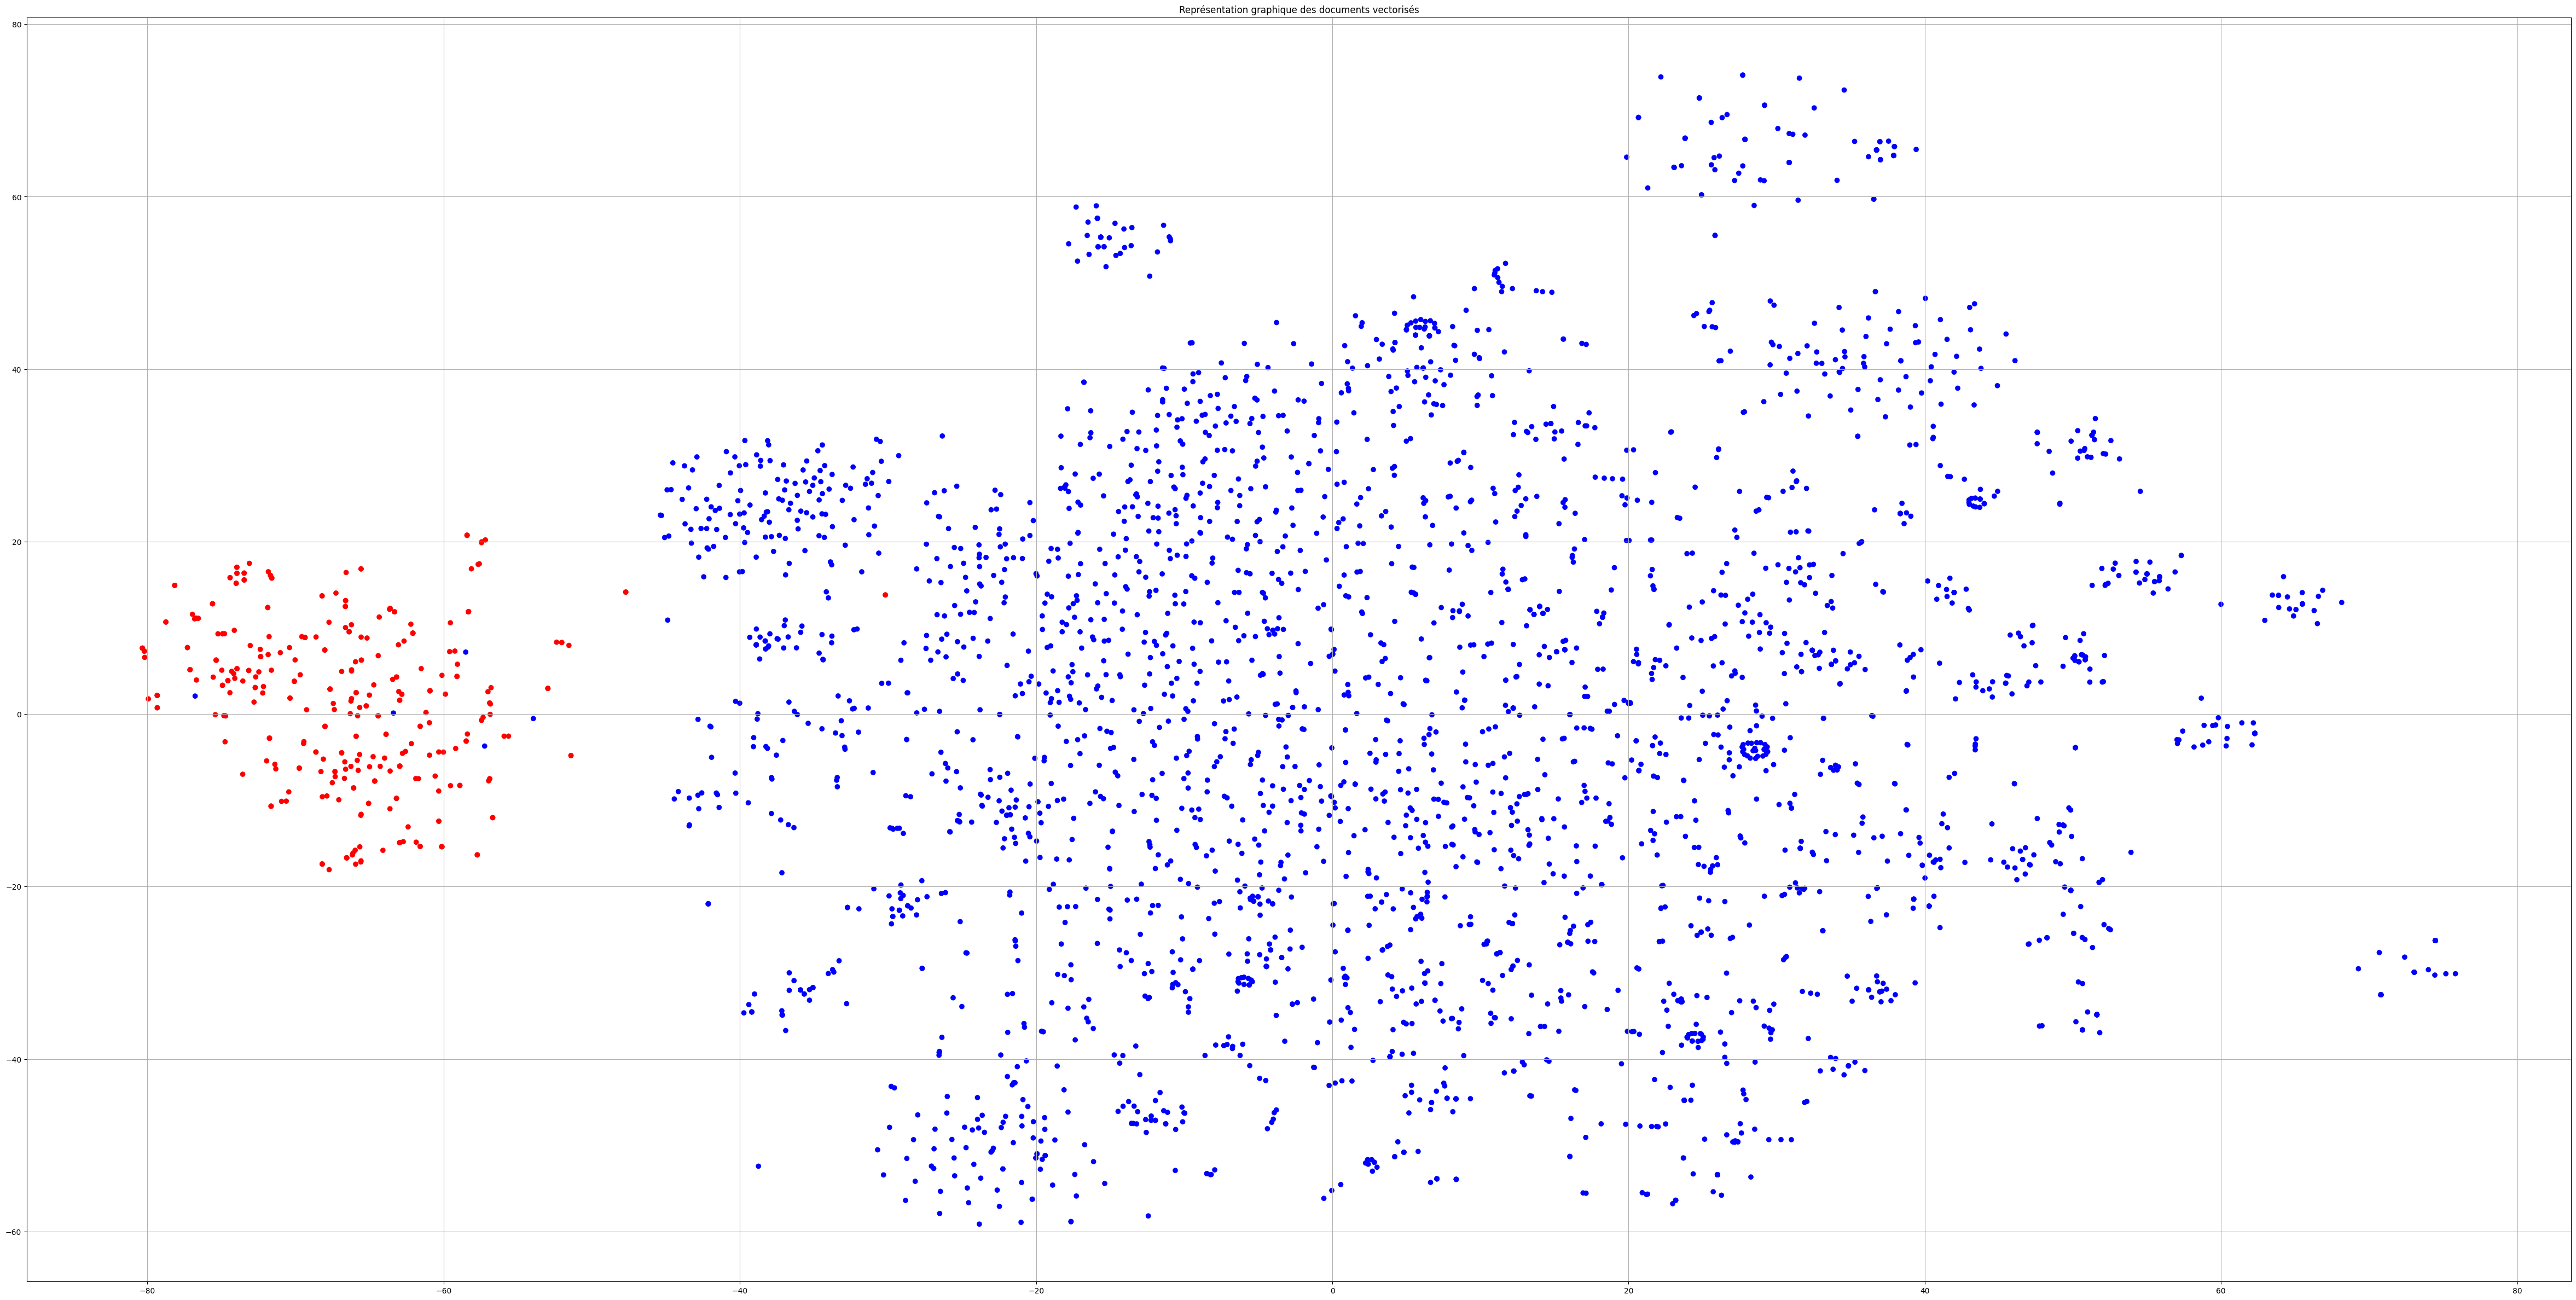

In [15]:
X_glove = vectorisation_glove(data_new, wv, ind)

In [16]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_glove, test_size=0.2, random_state=42)

# Initialisation et entraînement du modèle sur les données d'entraînement
model_iforest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model_iforest.fit(X_train)

# Prédiction sur l'ensemble d'entraînement et de test
y_pred_train = model_iforest.predict(X_train)
y_pred_test = model_iforest.predict(X_test)


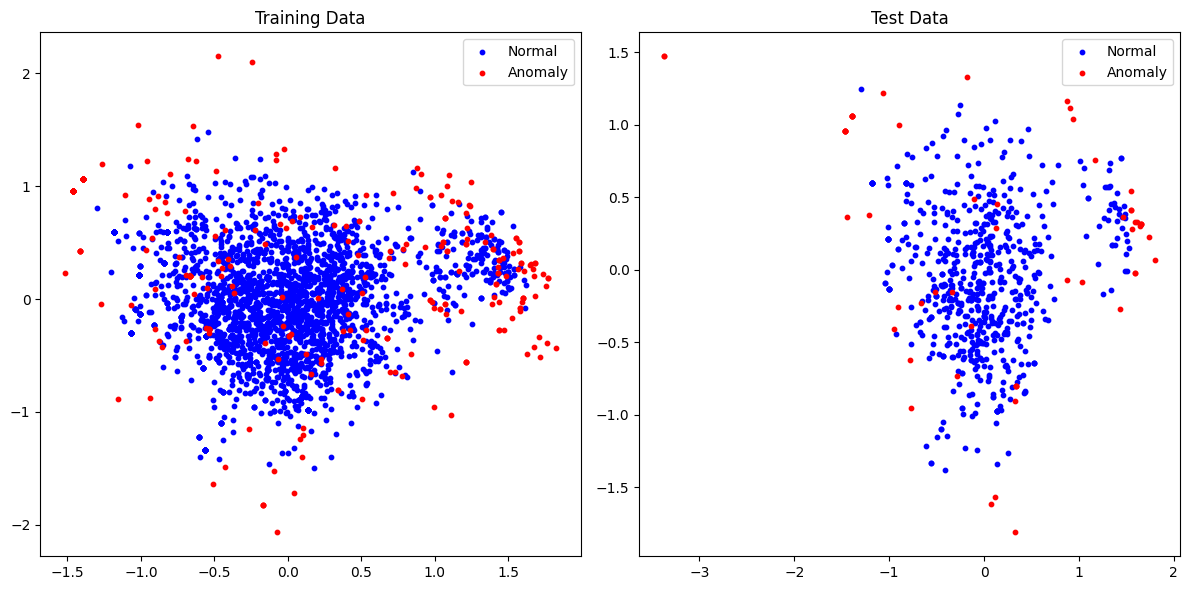

In [17]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fonction pour afficher les anomalies détectées
def create_scatter_plots(X1, y1, title1, X2, y2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Scatter plot pour les données d'entraînement
    axes[0].scatter(X1[y1 == 1, 0], X1[y1 == 1, 1], color='blue', label='Normal', s=10)
    axes[0].scatter(X1[y1 == -1, 0], X1[y1 == -1, 1], color='red', label='Anomaly', s=10)
    axes[0].set_title(title1)
    axes[0].legend()

    # Scatter plot pour les données de test
    axes[1].scatter(X2[y2 == 1, 0], X2[y2 == 1, 1], color='blue', label='Normal', s=10)
    axes[1].scatter(X2[y2 == -1, 0], X2[y2 == -1, 1], color='red', label='Anomaly', s=10)
    axes[1].set_title(title2)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Affichage des anomalies détectées
create_scatter_plots(X_train_pca, y_pred_train, 'Training Data', X_test_pca, y_pred_test, 'Test Data')